<div style="font-family:verdana;"><span style="font-size:170%;"> <center>Author Identification Using a Statistical NLP Approach</center> </span>
<span style="font-size:135%;"> <center>Feature engineering and model pipeline development with the <i>Spooky Author Identification</i> competition data</center> </span>
</div>

## Overview of notebook
- I develop a statistical Natural Langauge Processing (NLP) model to identify authors of texts from the <i>Spooky Author Identification</i> competition.
- Feature engineering consists of style-based features (count of punctuation, word length, etc.) and word- and character-based TF-IDF.
- Term frequency-inverse document frequency (TF-IDF) and bag-of-words feature extraction is discussed with a few simple examples.
- Feature engineering and models are combined in a pipeline, which makes model fitting and prediction easy, and also reduces the chance of data leakage from the text processing.
- XGBoost model does well with style-based features only, but Multinomial Naive Bayes performs better with TF-IDF features as well.

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">1. Introduction</p>

I find Natural Language Processing (NLP) machine-learning problems fascinating. Whereas numerical variables fit nicely into a regression model paradigm, text does not. Categorical features in more traditional problems can be encoded as ordinal or one-hot variables, but this approach doesn't make sense when data is text-based, not least because there are two many words to encode.

The Spooky Author ID competition is concerned with identifying which of three authors wrote given sentences. The data is sentences extracted from the works of three "spooky" authors:
Edgar Allan Poe (EAP), H.P. Lovecraft (HPL) and Mary Wollstonecraft Shelley (MWS). I first encountered this competition when it came out in 2017 and had an attempt at hand engineering some features, but I didn't really know anything about ML at the time. Since then I like to think I've learnt a few things and I had another go at putting together a model that would work at this competition.

## 1.1 Rogues' gallery

<table>
    <tr>
        <th> Edgar Allan Poe</th>
        <th> H.P. Lovecraft</th>
        <th> Mary Wollstonecraft Shelley</th>
    </tr>
  <tr>
    <th><img src="https://upload.wikimedia.org/wikipedia/commons/9/97/Edgar_Allan_Poe%2C_circa_1849%2C_restored%2C_squared_off.jpg" width="711", height="1000" /></th>
    <th><img src="https://upload.wikimedia.org/wikipedia/commons/1/10/H._P._Lovecraft%2C_June_1934.jpg" width="815" height="1000" /></th>
    <th><img src="https://upload.wikimedia.org/wikipedia/commons/c/ce/MaryShelley.jpg" width="712" height="1000" /></th>
  </tr>
    <tr>
        <th>Unknown author; Restored by Yann Forget and Adam Cuerden, Public domain, via Wikimedia Commons</th>
        <th>Lucius B. Truesdell, Public domain, via Wikimedia Commons</th>
        <th>Richard Rothwell, Public domain, via Wikimedia Commons</th>
    </tr>

</table>



## 1.2 Notebook overview

After reading in the data and setting up a few parameters, I outline the feature engineering approach I used. This is divided into three parts: 1) style-based features (use of punctuation, word length, etc.), 2) word-frequency (use of frequency of particular words), and 3) character-frequency features based on ngrams (i.e. strings of consecutive letters within words).

Next, I set up a few different modelling pipelines based on the engineered features, and these include both the XGBoost Classifier and Multinomial Naive Bayes.



# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">2. Notebook preliminaries</p>

## 2.1 Read in data and set up notebook


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn import set_config
# This draws pipelines, etc. as graph diagrams rather than the standard text-based repr. 
set_config(display='diagram')

xgboost_tree_method = 'auto'#'gpu_hist  # Use GPU for xgboost tree building or not?
QUICKRUN = False # Set equal to True to run a quick version of the notebook

/kaggle/input/spooky-author-identification/train.zip
/kaggle/input/spooky-author-identification/test.zip
/kaggle/input/spooky-author-identification/sample_submission.zip


## 2.2 Overview of data

In [2]:
data = pd.read_csv('/kaggle/input/spooky-author-identification/train.zip')
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [4]:
sample = pd.read_csv('/kaggle/input/spooky-author-identification/sample_submission.zip')
test = pd.read_csv('/kaggle/input/spooky-author-identification/test.zip')
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB


The training data consists of 19579 sentences with one of the three authors as labels, and the test data is 8392 unlabelled sentences. In constructing the style-based features, I found that the length of the sentence and the number of words in the sample sentence were useful to get proportions so I include these as two columns in both the training and test dataset

In [6]:
print(set(data['author']))

{'HPL', 'EAP', 'MWS'}


The texts are writte by one of three authors: Edgar Allan Poe, H.P. Lovecraft and Mary Wollstonecraft Shelley.

## 2.3 Brief biographical sketches of the authors


<img src="https://upload.wikimedia.org/wikipedia/commons/9/97/Edgar_Allan_Poe%2C_circa_1849%2C_restored%2C_squared_off.jpg" width="152" align="left" style="padding: 0px 50px 0px 0px" alt = "Edgar Allan Poe">
<p>Edgar Allan Poe (1809-1840) was an American author, best known for the poem "The Raven" and his short stories (tales), especially "The Tell-Tale Heart", "The Murders in the Rue Morgue" and "The Fall of the House of Usher". He was obsessed with being buried alive and the "spooky" aspect of his writing was consistently those things within our minds, or the "terror of the soul". "The Tell-Tale Heart" is a case in point, being a study of the all-consuming dread of guilt. Poe is also considered to have pioneered the detective novel, and was fascinated with cryptography, particularly substitution cyphers ("The Gold Bug"), which interestingly enough has relevance to the character-level TF-IDF we explore later.

The cause and circumstances of his death in Baltimore are still a mystery.</p>

In [7]:
np.random.seed(123)
np.random.choice(data.loc[data['author']=='EAP','text'])

'You are well aware that chemical preparations exist, and have existed time out of mind, by means of which it is possible to write upon either paper or vellum, so that the characters shall become visible only when subjected to the action of fire.'

<img src="https://upload.wikimedia.org/wikipedia/commons/1/10/H._P._Lovecraft%2C_June_1934.jpg" width="152" align="right" style="padding: 0px 0px 0px 50px" alt = "H.P Lovecraft">
<p>H.P. Lovecraft (1890-1937) was also from the USA, and similar to EAP, wrote mostly short stories. Best known for "The Call of Cthulu", "At the Mountains of Madness" and other stories, he was relatively unknown and earned little from his writing during his lifetime. A revival of his works occurred around the 1970s. Lovecraft's fiction centers around a pantheon of cosmic beings ("Old Ones") and knowledge whose revelation to humans typically leads to madness. 

Lovecraft died from intestinal cancer after a long and painful hospitalization.</p>

In [8]:
np.random.choice(data.loc[data['author']=='HPL','text'])

'The pile of tools soon reached, and a hammer and chisel selected, Birch returned over the coffins to the door.'


<img src="https://upload.wikimedia.org/wikipedia/commons/c/ce/MaryShelley.jpg" width="152" align="left" style="padding: 0px 50px 0px 0px" alt = "Mary Wollstonecraft Shelley">
    
<p>Mary Wollstonecraft Shelley (1759-1797), also known as Mary Shelley and Mary Godwin, was best known for our purposes for writing "Frankenstein: or, the Modern Prometheus", one of the best known "gothic" novels, and "Mathilda". She was (eventually) married to the English Romantic poet Percy Bysshe Shelley. MWS also wrote autobiographical accounts of travels with Shelley and works on politics and gender. Her mother, Mary Wollstonecraft was a women's rights advocate and wrote the hugely influential "A Vindication of the Rights of Woman".

After what must have been a wild and unconvential life at the time, she died after a painful illness. Upon her death, her family found the cremated remains of Shelley's heart wrapped in a copy of his poem Adonaïs.</p>

In [9]:
np.random.choice(data.loc[data['author']=='MWS','text'])

'A moment more and Perdita appeared; she stood before me in the fresh bloom of youthful womanhood, different from and yet the same as the mountain girl I had left.'

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">3. Feature engineering</p>

Let's start by engineering some features based on the writing style (but not yet on particular words used). 

## 3.1 Text length

As far as I can tell, most, if not all, of the texts are single sentences. Perhaps the most obvious feature that we can engineer is the number of characters ('text_length') and number of words ('nwords') in each text (sentence). Whereas most of the engineered features are implemented as transformers to fit into pipelines and the like, I created these two initially by hand to speed the feature engineering up.

In [10]:
data['text_length'] = data['text'].map(lambda x: len(x.strip()))
data['nwords'] = data['text'].map(lambda x: x.strip().count(' ')+1)

test['text_length'] = test['text'].map(lambda x: len(x.strip()))
test['nwords'] = test['text'].map(lambda x: x.strip().count(' ')+1)


In [11]:
print(f'Sample text:          {data.loc[238,"text"]}\nvalue of text_length: {data.loc[238,"text_length"]}')

Sample text:          Then with utter and horrifying suddenness we heard a frightful sound from below.
value of text_length: 80


To create classes for the transformations, it is useful to inherit a few things from the scikit-learn base classes `TransformerMixin` and `BaseEstimator` (which provide the methods required by a pipeline), and then just write a `transform` method. To begin with, let's create a transformation that just takes the text_length column. The `transform` method returns a column vector (i.e. shape $1 \times N$ rather than a vector) using `np.newaxis`, which is useful when combining columns in `FeatureUnion`.

In [12]:
from sklearn.base import TransformerMixin, BaseEstimator
class FeatureExtractionClass(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

class TextLength(FeatureExtractionClass):
    def transform(self, X, y=None):
        return np.array(X['text_length'])[:,np.newaxis]

The longest sentence in the dataset (written by MWS) contains over 4500 characters!


In [13]:
data.loc[np.argmax(TextLength().transform(data)),'text']

'Diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her Without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before I attempt to repeat her words I will describe the chief of these whom she appeared to wish principally to impress One was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in ringlets on her shoulders her hazle eyes were shaded by heavy lids and her mouth the lips apart seemed to breathe sensibility But she appeared thoughtful unhappy her cheek was pale she seemed as if accustomed to suffer and as if the lessons she now heard were the only words of wisdom to which she had ever listened The youth beside her had a far different aspect his form was emaciated nearly to a shadow his features were handsome but thin worn his eyes glistened as if animating the visage of deca

Since these authors are by now in the public domain, the original text is available online, and this sentence is a compound [sentence separated with em-dashes](http://www.online-literature.com/shelley_mary/mathilda/14/) rather than full stops, where the dashes have been removed in the text provided to us. Recreating the dashes and/or separating this out looks like a fairly formidable task so we can leave it as it is. At any rate, maybe this kind of writing will be repeated again so it could be useful to identify authors. 

Let's have a look at how text length distribution differs among the three authors, cutting off the y-axis of the next figure at 1000 characters: 

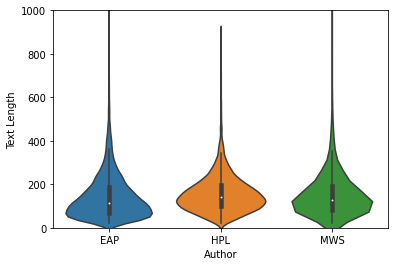

In [14]:
ax=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 
                                    'Text Length': TextLength().transform(data).ravel()}), 
                 x="Author", y="Text Length")
#ax.set_yscale('log')
_=ax.set_ylim([0,1000])

There does seem to be a tendency for EAP to write short, punchy sentences occasionally, and HPL tends to have a smaller variability in sentence length than the other two authors. Could be useful!

## 3.2 Punctuation

Use of punctuation can be highly idiomatic, so let's engineer a few features involving this. Pick a random example sentence from the dataset:


In [15]:
sample_txt=data['text'][123]
print(sample_txt)

They had received orders that if I were again taken, I should be brought to the Earl; and his lenity made them expect a conclusion which they considered ill befitting my crime.


Here we have one comma, a semicolon and a fullstop. 

A list of ASCII punctuation symbols is provided in the python `string` package:

In [16]:
import string
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

The `re` (regular expression operations) [module](https://docs.python.org/3/library/re.html) is useful for processing text. It is pretty useful, and I have used this previously for extracting info from strings with a fixed pattern, e.g. the "a" within the brackets from "Example 3(a)". In this notebook, however we use `re` just to find and count characters or words in strings.   

Use of the square brackets in a re pattern is like uysing a boolean "or" operator for individual characters:

In [17]:
import re
re.compile("[" + punct + "]").findall(sample_txt)

[',', ';', '.']

Let's make two features, punctuation count as a proportion of text length, and count of semicolons used in the text. The 'text_length' column we made previously is useful for the punctuation proportion feature.

In [18]:
class CountPunctuationProp(FeatureExtractionClass):
    def transform(self, X, y=None):
        punctuation_count = [len(re.compile("[" + punct + "]").findall(txt)) for txt in X['text']]
        return np.array(np.array(punctuation_count)/X['text_length'])[:,np.newaxis]
class CountSemicolons(FeatureExtractionClass):
    def transform(self, X, y=None):
        punctuation_count = np.array([len(re.compile(";").findall(txt)) for txt in X['text']])[:,np.newaxis]
        return punctuation_count

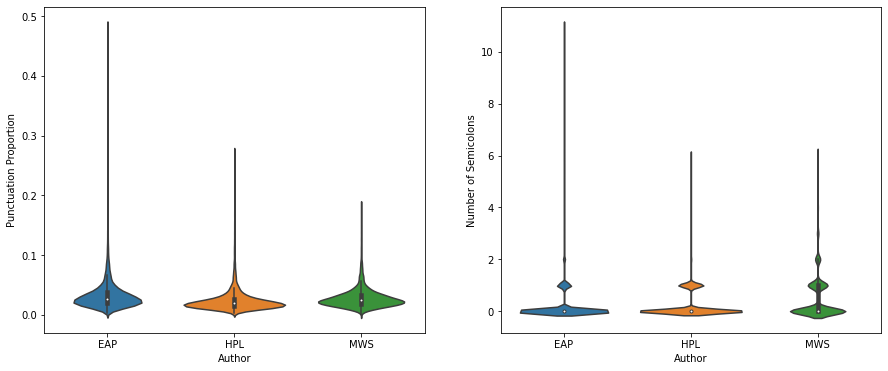

In [19]:

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Punctuation Proportion': CountPunctuationProp().transform(data).ravel()}), 
                 x="Author", y="Punctuation Proportion")
plt.subplot(1,2,2)
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Number of Semicolons': CountSemicolons().transform(data).ravel()}), 
                 x="Author", y="Number of Semicolons")

It looks like Edgar Allan Poe used quite a bit more punctuation (as well as semicolons) than both the other authors, although as we have seen, em-dashes were edited out in the exceprt from Mary Wollstonecraft Shelley above, so these features might not be a true representation of punctuation usage.

## 3.3 Word length

So far we've just looked at characters in sentences. Word length can vary substantially between authors and could be a good way of telling authors apart. 

I initially implemented word length just by counting the number of spaces, but there's more sophisticated ways of doing this. The `re` module could be used again, but the python Natural Language Toolkit ([nltk](https://www.nltk.org/)) has an inbuilt tokenizer to do exactly what we want.

In [20]:
from nltk.tokenize import RegexpTokenizer
qword_tokenizer = RegexpTokenizer(r'\w+')
words = qword_tokenizer.tokenize(sample_txt)
print(words)

['They', 'had', 'received', 'orders', 'that', 'if', 'I', 'were', 'again', 'taken', 'I', 'should', 'be', 'brought', 'to', 'the', 'Earl', 'and', 'his', 'lenity', 'made', 'them', 'expect', 'a', 'conclusion', 'which', 'they', 'considered', 'ill', 'befitting', 'my', 'crime']


NLTK has nicely separated out words, and punctuation has been lost. However, apostrophes prove problematic, as can be seen in the following example:

In [21]:
print(qword_tokenizer.tokenize("I can't do it"))

['I', 'can', 't', 'do', 'it']


As can be seen, "can't" is separated into two words here. Removal of stop words could resolve this, but possessives ("Robert's cloak") would need to also be handled. Nevertheless, we can engineer a few features based on word length using the nltk function.

## 3.4 Number of words in text

In [22]:
class CountWords(FeatureExtractionClass):
    def transform(self, X, y=None):
        #return np.array(data['nwords'])[:,np.newaxis]
        return np.array([len(qword_tokenizer.tokenize(txt)) for txt in X['text']])
CountWords().transform(data)

array([41, 14, 36, ..., 13, 15, 22])

The nltk tokenizer provides a very similar word count to just counting spaces:

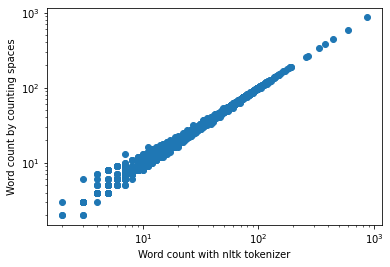

In [23]:
ax = plt.loglog(CountWords().transform(data).ravel(), data['nwords'],'o')
_=plt.gca().set_ylabel('Word count by counting spaces')
_=plt.gca().set_xlabel('Word count with nltk tokenizer')

## 3.5 Average word length

Whereas counting spaces is probably just as good as the nltk tokenizer for counting words, the tokenizer provides us with the words themselves in a list, so we can use these to calculate mean and standard deviation of word length. 

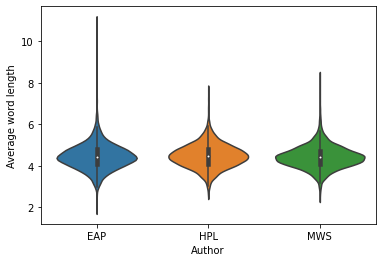

In [24]:
class AvWordLength(FeatureExtractionClass):
    def transform(self, X, y=None):
        return np.array([np.mean([len(x) for x in qword_tokenizer.tokenize(txt)]) for txt in X['text']])[:,np.newaxis]
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Average word length': AvWordLength().transform(data).ravel()}), 
                 x="Author", y="Average word length")

However, I recently discovered that the mean of word length is surprisingly constant across different texts, so I don't use this in the model.

## 3.6 Standard deviation of word length

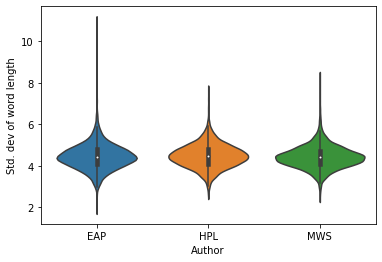

In [25]:
class StdWordLength(FeatureExtractionClass):
    def transform(self, X, y=None):
        return np.array([np.std([len(x) for x in qword_tokenizer.tokenize(txt)]) for txt in X['text']])[:,np.newaxis]
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Std. dev of word length': AvWordLength().transform(data).ravel()}), 
                 x="Author", y="Std. dev of word length")


## 3.7 Stop words

Stop words are words that play a role in syntax but are essentially meaningless in relation to the sentence content. Often in NLP they are removed from texts before processing.

However, the use and frequency of stop words can be an important determinant in a writer's style. The notebooks referenced in the introduction (and elsewhere) both consider stop word count as a feature, so I include it as well. Here we use stopwords from [NLTK](https://pythonspot.com/nltk-stop-words/).

In [26]:
import nltk
from nltk.corpus import stopwords

eng_stopwords = set(stopwords.words("english"))
list(eng_stopwords)[:10]

['about',
 'yours',
 'when',
 'into',
 'between',
 'shouldn',
 "should've",
 'now',
 'yourself',
 'were']

We can use the `re` module to search through the texts to locate particular words.

In [27]:
import re

stop_sample_txt = data.loc[2,'text']
stop_sample_txt

'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'

We need to be careful how regular expressions are compiled:

In [28]:
re.compile('as').findall(stop_sample_txt.lower())

['as', 'as', 'as']

Searching for the regular expression "as" picks up "as" in "was" and "fantastic", as well as the whole word "as". The correct way to search for [whole words only](https://docs.python.org/3/library/re.html#regular-expression-syntax) is to surrounding the regular expression with "\b".

In [29]:
re.compile(r'\bas\b').findall(stop_sample_txt.lower())

['as']

which works how we'd like. Let's create a transformer that extracts a list of any particular set of words (not just stop words).

In [30]:
class XtractWords(FeatureExtractionClass):
    def __init__(self, word_list):
        self.words = word_list
    def transform(self, X, y=None):
        word_occurrences = [re.compile("\b" + r"\b|\b".join(self.words) + "\b").findall(txt.lower()) for txt in X['text']]
        return word_occurrences
    

The above implementation was really slow, and made the whole model building pipeline pretty much unusable. A moment's thought reveals that sequentially comparing words like in the above is a really inefficient way of doing things. When we look up someone's name in a phone directory (young people: what's that?) we don't compare every word, rather we drill down recursively comparing each letter in turn. By setting up a properly balanced prefix (radix) tree, known as a trie, we can achieve much better performance. 

[Eric Duminil](https://stackoverflow.com/a/42789508/14278409) provided an awesome answer on stackoverflow that does exactly this.

In [31]:
# Faster regex search using tries
# Awesome answer from here
# https://stackoverflow.com/a/42789508/14278409

class Trie():
    """Regex::Trie in Python. Creates a Trie out of a list of words. The trie can be exported to a Regex pattern.
    The corresponding Regex should match much faster than a simple Regex union."""

    def __init__(self):
        self.data = {}

    def add(self, word):
        ref = self.data
        for char in word:
            ref[char] = char in ref and ref[char] or {}
            ref = ref[char]
        ref[''] = 1

    def dump(self):
        return self.data

    def quote(self, char):
        return re.escape(char)

    def _pattern(self, pData):
        data = pData
        if "" in data and len(data.keys()) == 1:
            return None

        alt = []
        cc = []
        q = 0
        for char in sorted(data.keys()):
            if isinstance(data[char], dict):
                try:
                    recurse = self._pattern(data[char])
                    alt.append(self.quote(char) + recurse)
                except:
                    cc.append(self.quote(char))
            else:
                q = 1
        cconly = not len(alt) > 0

        if len(cc) > 0:
            if len(cc) == 1:
                alt.append(cc[0])
            else:
                alt.append('[' + ''.join(cc) + ']')

        if len(alt) == 1:
            result = alt[0]
        else:
            result = "(?:" + "|".join(alt) + ")"

        if q:
            if cconly:
                result += "?"
            else:
                result = "(?:%s)?" % result
        return result

    def pattern(self):
        return self._pattern(self.dump())

def trie_regex_from_words(words):
    trie = Trie()
    for word in words:
        trie.add(word)
    return re.compile(r"\b" + trie.pattern() + r"\b", re.IGNORECASE)



Create a new transformer class using this to search for words in a given vocabulary using the trie regular expression, and a class that counts the number of words in the vocabulary in each text.

In [32]:
class XtractWordsFast(FeatureExtractionClass):
    def __init__(self, word_list):
        self.words = word_list
    def transform(self, X, y=None):
        re_pattern = trie_regex_from_words(self.words)
        word_occurrences = [re_pattern.findall(txt.lower()) for txt in X['text']]
        return word_occurrences
    
class CountStopsProp(FeatureExtractionClass):
    def __init__(self, stopwords):
        self.stopwords = stopwords
    def transform(self, X, y=None):
        stops_count = [len(x) for x in XtractWordsFast(self.stopwords).transform(X)]
        return np.array(np.array(stops_count) / X['text_length'])[:,np.newaxis]

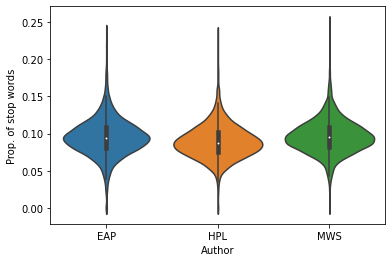

In [33]:
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Prop. of stop words': CountStopsProp(eng_stopwords).transform(data).ravel()}), 
                 x="Author", y="Prop. of stop words")

## 3.8 Feminine stop words

Some time ago I became interested in the frequency of words in the English language. Somewhat naively, I expected that since men and women make up approximately half of the population each, words like "he" and "she" should occur in approximately the same frequency. However, I was fairly shocked to discover that, in many different kinds of texts, masculine pronouns occur massively more frequently than feminine pronouns. 

It turns out that, for whatever reason, we write and read much more about men rather than women. In an early EDA I notice that MWS uses feminine pronouns more frequently that the other two authors, and this could also prove useful as a feature. We can reuse `CountStopsProp` with a feminine-specific vocabulary to engineer this feature.

In [34]:
feminine_stopwords = ['her', 'hers', 'herself', 'she', "she's"]

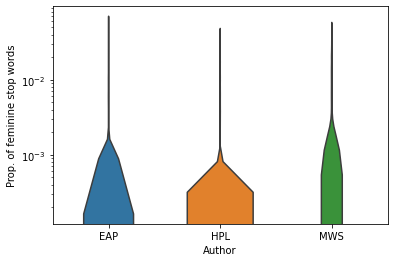

In [35]:
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 'Prop. of feminine stop words': CountStopsProp(feminine_stopwords).transform(data).ravel()}), 
                 x="Author", y="Prop. of feminine stop words")
plt.gca().set_yscale('log')

The stop-words figures show some difference in use of all stop words, and what could be a relatively larger difference in feminine stop words (although it's hard to see from the log-scale figure as the number of feminine stop words in use is overall quite small).

## 3.9 All-caps words

Another idiomatic use of words is the occurence of ALL-CAPS WORDS. 

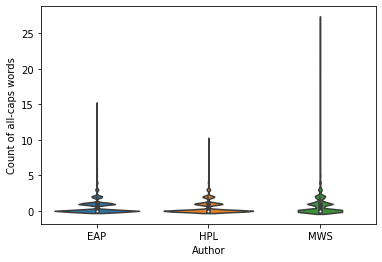

In [36]:


class CountAllcaps(FeatureExtractionClass):
    def transform(self, X, y=None):
        return np.array([len([z for z in qword_tokenizer.tokenize(txt) if z==z.upper()]) for txt in X['text']])[:,np.newaxis]
_=sns.violinplot(data=pd.DataFrame({'Author': data['author'], 
                                    'Count of all-caps words': CountAllcaps().transform(data).ravel()}), 
                 x="Author", y="Count of all-caps words")




# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">4. Combining feature extraction in a FeatureUnion</p>

In preparation for creating a model pipeline, we can combine the feature engineering steps as a `FeatureUnion`. I previously wrote a [notebook](https://www.kaggle.com/code/nnjjpp/tps-may-2022-using-a-pipeline) demonstrating a pipeline and the `ColumnTransformer`. The main reason for setting up a pipeline here is so that we can apply exactly the same feature engineering and preprocessing steps to the training and test dataset without rewriting code. Briefly,

- A [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) combines several steps (feature engineering, preprocessing, modelling) into one class so we can run everything with just one call to `fit`, and just as easily get predictions, scoring, etc.,
- A [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) combines several different column transformations operating on different columns (e.g. we may want to scale a particular numerical variable, and one-hot encode a categorical variable),
- A [FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) creates several features from consecutive passes through the dataset. Each transformer in a `FeatureUnion` operates on all columns of the dataset, whereas each transformer in a `ColumnTransformer` operates on a different column (or set of columns). 

Since we are engineering different features from the one column (i.e. the 'text' column), we initially need a `FeatureUnion`. 

In [37]:
from sklearn.pipeline import FeatureUnion
StyleExtractor = FeatureUnion([('text_length',TextLength()),
                               ('punctuation_proportion', CountPunctuationProp()),
                               ('semicolon_count', CountSemicolons()),
                               #('mean_word_length', AvWordLength()),
                               ('std_word_length',StdWordLength()),
                               ('stopwords_proportion', CountStopsProp(eng_stopwords)),
                               ('feminine_stopwords_proportion', CountStopsProp(feminine_stopwords)),
                               ('allcaps_count', CountAllcaps()),
                              ])
StyleExtractor

FeatureUnion(transformer_list=[('text_length', TextLength()),
                               ('punctuation_proportion',
                                CountPunctuationProp()),
                               ('semicolon_count', CountSemicolons()),
                               ('std_word_length', StdWordLength()),
                               ('stopwords_proportion',
                                CountStopsProp(stopwords={'a', 'about', 'above',
                                                          'after', 'again',
                                                          'against', 'ain',
                                                          'all', 'am', 'an',
                                                          'and', 'any', 'are',
                                                          'aren', "aren't",
                                                          'as', 'at', 'be',
                                                          'because', 'been',
                                                          'before', 'being',
                                                          'below', 'between',
                                                          'both', 'but', 'by',
                                                          'can', 'couldn',
                                                          "couldn't", ...})),
                               ('feminine_stopwords_proportion',
                                CountStopsProp(stopwords=['her', 'hers',
                                                          'herself', 'she',
                                                          "she's"])),
                               ('allcaps_count', CountAllcaps())])

Let's try it out to make sure it works how we expect:

In [38]:
data.loc[:5, ['author', 'text']].join(pd.DataFrame(StyleExtractor.transform(data.loc[15:20,:]),
                                                    columns = [x[0] for x in StyleExtractor.transformer_list]))
             


,author,text,text_length,punctuation_proportion,semicolon_count,std_word_length,stopwords_proportion,feminine_stopwords_proportion,allcaps_count
0,EAP,"This process, however, afforded me no means of...",261.0,0.019157,0.0,2.516761,0.088123,0.000000,2.0
1,HPL,It never once occurred to me that the fumbling...,340.0,0.029412,2.0,2.712805,0.100000,0.000000,4.0
2,EAP,"In his left hand was a gold snuff box, from wh...",173.0,0.023121,0.0,2.889990,0.075145,0.017341,0.0
3,MWS,How lovely is spring As we looked from Windsor...,270.0,0.025926,0.0,3.088959,0.092593,0.000000,2.0
4,HPL,"Finding nothing else, not even gold, the Super...",305.0,0.029508,1.0,3.082142,0.072131,0.000000,0.0
5,MWS,"A youth passed in solitude, my best years spen...",111.0,0.018018,0.0,2.486243,0.099099,0.000000,0.0


# <p style="background-color:darkred;color:white;font-family:verdana;text-align:center;font-size:120%;border-radius: 15px 50px;">5. Baseline model using style-only features</p>

Naive Bayes models are often used for document classification problems, and has been very successful for developing spam filters. Based on Bayes Theorem, such a model calculates the presence or absence of particular words as evidence for different classifications. For example, the word "bitcoin" in an email provides fairly strong evidence for an email being spam. Each feature is then applied independently, which makes a Naive Bayes model scalable and very fast to fit and calculate predictions.  Naive Bayes models are surprisingly effective, in spite of their simplicity. I created a [notebook exploring the gaussian Naive Bayes model](https://www.kaggle.com/code/nnjjpp/the-naive-bayes-classifier), which you may find interesting. Multinomial Naive Bayes models are normally used for document classification models over gaussian models since text features are typically count-based features, as we'll see below, whereas gaussian models are based on the assumption that zero evidence occurs at the mean value rather than zero. 

To get started with any model, we need to encode the author strings as ordinals, i.e. as (0, 1, 2).

In [39]:
from sklearn.preprocessing import LabelEncoder
author_encoder = LabelEncoder()
author_codes = author_encoder.fit_transform(data['author'])
authors012 = list(author_encoder.inverse_transform(range(3)))

import itertools as it
for encoding in zip(author_encoder.classes_, it.count()):
    print(f'{encoding[0]} encoded as {encoding[1]}')

EAP encoded as 0
HPL encoded as 1
MWS encoded as 2


## 5.1 Multionmial Naive Bayes

For the initial model, let's fit a [mutinomial Naive Bayes model](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) just to the style-based features:

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

mnb_pipe = Pipeline([('style_features', StyleExtractor),
                     ('MNB', MultinomialNB())])

from sklearn.metrics import log_loss
mnb_pipe.fit(data, author_codes)

mn_author_probs = mnb_pipe.predict_proba(data)

log_loss(author_codes, mn_author_probs)

1.0578702934145252

In [41]:
from sklearn.model_selection import cross_validate, StratifiedKFold
sfold5 = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 123)
baseline_cv_results = cross_validate(estimator = mnb_pipe,
                                     cv = sfold5, 
                                     scoring = "neg_log_loss", 
                                     return_estimator = True,
                                     X = data, y=author_codes)
print(f'Cross-validated (3-fold) log-loss error from baseline model: {-np.mean(baseline_cv_results["test_score"]):.3f}')

Cross-validated (3-fold) log-loss error from baseline model: 1.058


The baseline MNB model with style features does a tiny bit better than the score of 1.09 from the sample submission (which just takes prediction probabilities equal to the observed proportion of authors in the training dataset).

[[6268  603 1029]
 [4208  497  930]
 [3830  318 1896]]


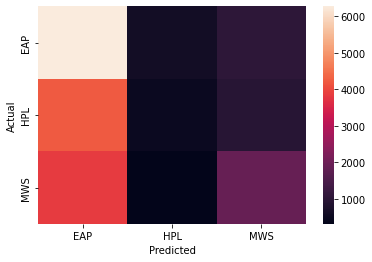

In [42]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model_probs):
    cm = confusion_matrix(author_codes, np.argmax(model_probs,1))
    print(cm)
    ax = sns.heatmap(cm,
           xticklabels=authors012,
           yticklabels=authors012)
    _=ax.set_xlabel('Predicted')
    _=ax.set_ylabel('Actual')
plot_confusion_matrix(mn_author_probs)

The calibration confusion matrix doesn't look great, and the baseline model basically looks like the sample submission. However, let's have a look at the validation confusion matrix (calculated on the output from `cross_validate()`):

Cross-validated confusion matrix: baseline model
Fold 1: cv log loss: 1.059
Fold 2: cv log loss: 1.058
Fold 3: cv log loss: 1.060
Fold 4: cv log loss: 1.056
Fold 5: cv log loss: 1.059
[[6262  612 1026]
 [4204  496  935]
 [3830  317 1897]]


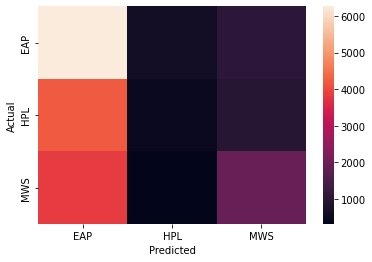

In [43]:
def plot_cv_confusion_matrix(cross_validate_output, cv_splitter):
    # cross_validate_output is output from cross_validate
    # note we need `return_estimator=True`
    cv_probs = np.zeros((data.shape[0],3))
    for i,xy in enumerate(cv_splitter.split(data, author_codes)):
        fold_ix=xy[1]
        cv_probs[fold_ix,:] = cross_validate_output['estimator'][i].predict_proba(data.iloc[fold_ix,:])
        print(f"Fold {i+1}: cv log loss: {log_loss(data.iloc[fold_ix,:]['author'],cv_probs[fold_ix,:]):.3f}")
    plot_confusion_matrix(cv_probs)
print('Cross-validated confusion matrix: baseline model')
plot_cv_confusion_matrix(baseline_cv_results, sfold5)

There's not too much difference between calibration and validation confusion matrix. Let's see if XGBoost can do any better:

## 5.2 XGBoost Classifier

[XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) is pretty much my go-to model these days, and works for pretty much anything.

In [44]:
from xgboost import XGBClassifier
xgb_pipe = Pipeline([('style_features', StyleExtractor),
                     ('xgb', XGBClassifier(n_estimators = 100,
                                           tree_method = xgboost_tree_method)),])
xgb_pipe.fit(data, author_codes)

xgb_author_probs = xgb_pipe.predict_proba(data)

print(log_loss(author_codes, xgb_author_probs))

0.7220088461776396


In [45]:
xgb_baseline_cv_results = cross_validate(estimator = xgb_pipe,
                                         cv = sfold5, 
                                         scoring = "neg_log_loss", 
                                         return_estimator=True,
                                         X = data, y=author_codes)
print(f'Cross-validated (3-fold) log-loss error from XGB baseline model: {-np.mean(xgb_baseline_cv_results["test_score"]):.3f}')

Cross-validated (3-fold) log-loss error from XGB baseline model: 0.958


Fold 1: cv log loss: 0.960
Fold 2: cv log loss: 0.953
Fold 3: cv log loss: 0.950
Fold 4: cv log loss: 0.951
Fold 5: cv log loss: 0.977
[[5293 1378 1229]
 [1827 3099  709]
 [2585 1215 2244]]


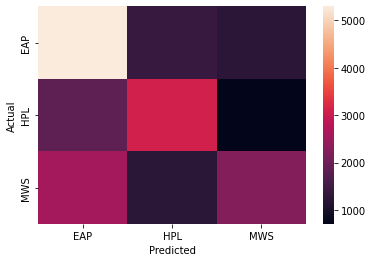

In [46]:
plot_cv_confusion_matrix(xgb_baseline_cv_results, sfold5)

This looks quite a bit better than the Naive Bayes model, we can also use the XGBoost model to get feature importances, something which is difficult (if not impossible) to do with the NB model.

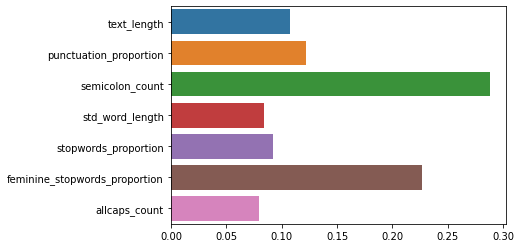

In [47]:

_=sns.barplot(y=[x[0] for x in StyleExtractor.transformer_list],
            x=xgb_pipe.steps[1][1].feature_importances_)


Looks like we have engineered a few useful features. Interestingly, the use of semicolons and feminine stop words turned out to be very important features. 

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">6. Engineering features from words and characters</p>

This section describes how to engineer word- and character-based features. In it, I provide examples of Bag Of Words and Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. Those already familiar with this may wish to skip ahead to the next section.

## 6.1 Word level feature engineering

So far we have engineered features based on things like word length, punctuation and stop-word proportion. The count of feminine stop words was the first attempt to extract information about the actual content of the texts (specifically the hypothesis that MWS would write about women more often that EAP and HPL). 

Extending this idea, why not take a count of all (or almost all) words in the texts and use this information to identify authors? After all, different authors will be writing about different concepts and probably have favourite words. The two main ways of doing this are Bag-of-Words and TF-IDF. The book "Feature Engineering for Machine Learning" By Alice Zheng and Amanda Casari (O'Reilly, 2018) provides a good explanation of these. Essentially:

- Bag-of-words feature engineering creates counts of words in each text, and returns a (normally sparse) set of vectors. It's kind of like word-level one hot encoding  but with frequencies.

- Term frequency-Inverse document frequency (TF-IDF) vectorization does something similar, but more frequent words are weighted less than rarer words. 

Normally, stop-words are excluded, punctuation is removed and everthing is converted to lower-case.

Let's take a look using a couple of made-up examples:

In [48]:
silly_examples = ['Cat on the mat',
                  'Mat rat',
                  'The cat, the rat and the baseball bat',
                  'Cats are OK',
                  'Dude, where is my car, cat and fast car',
                  'Fast and bulbous',
                  'The cat that likes cats loves TV',
                  'I don''t know what you are talkin'' about']

### 6.1.1 Bag of words

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

countVec = CountVectorizer(stop_words='english')
bag_of_words = countVec.fit_transform(silly_examples)

bow = pd.DataFrame(data=bag_of_words.todense(),index=silly_examples,columns = countVec.get_feature_names_out())
bow

,baseball,bat,bulbous,car,cat,cats,dont,dude,fast,know,likes,loves,mat,ok,rat,talkin,tv
Cat on the mat,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
Mat rat,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
"The cat, the rat and the baseball bat",1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
Cats are OK,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
"Dude, where is my car, cat and fast car",0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0
Fast and bulbous,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
The cat that likes cats loves TV,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1
I dont know what you are talkin about,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


The output from `CountVectorizer` contains the count of each word in the vocabulary (essentially every word in the data except for excluded stop words) for each text in the corpus. Note that, as punctuation is removed, "don't" becomes "dont" which could cause problems in certain instances but is probably OK. Also, "cat" and "cats" are considered separate words. Depending on the level of detail required, a more sophisticated [approach](https://en.wikipedia.org/wiki/Stemming) (i.e. [stemming](https://stackoverflow.com/questions/45336491/sklearn-feature-extraction-from-text-normalize-text-features-by-merging-plur)) may be useful. I haven't used it but the [NLTK stemming module](https://www.nltk.org/api/nltk.stem.html) looks good for this.

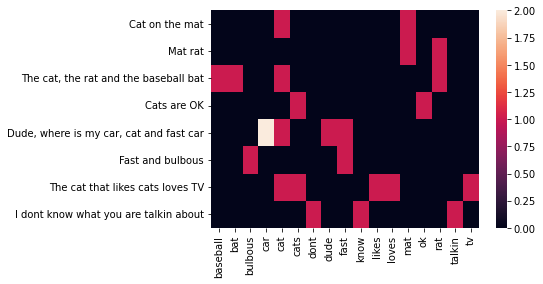

In [50]:
_=sns.heatmap(bow)

### 6.1.2 TF-IDF (Text frequency-inverse document frequency)

Bag of words is useful, but suffers from a particular problem. When every text is about cats, the occurrence of the word "cat" doesn't really provide much information as every author is going to be using the word "cat" a lot. More information should be present if an author uses a relatively rare word a lot compared to frequent occurrences of common words. Specifically, it would be good to weight less frequent words more. Enter [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Essentially, the TF-IDF score of a particular word in a text is given by:

$$ \mathrm{TFIDF}(\text{word}; \text{document}) = \frac{\text{frequency of word in document}}{\text{relative rareness of word across all documents}}$$

There are some subtleties involved, and different ways to calculate these. 

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_features=None, 
                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                ngram_range=(1, 1), 
                stop_words = 'english')

tfidf = tfidf_vec.fit_transform(silly_examples)
tfidf_df = pd.DataFrame(data=tfidf.todense(),index=silly_examples,columns = tfidf_vec.get_feature_names_out())

tfidf_df

,baseball,bat,bulbous,car,cat,cats,dont,dude,fast,know,likes,loves,mat,ok,rat,talkin,tv
Cat on the mat,0.000000,0.000000,0.00000,0.000000,0.603358,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.797471,0.00000,0.000000,0.00000,0.000000
Mat rat,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.707107,0.00000,0.707107,0.00000,0.000000
"The cat, the rat and the baseball bat",0.567556,0.567556,0.00000,0.000000,0.359876,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.475656,0.00000,0.000000
Cats are OK,0.000000,0.000000,0.00000,0.000000,0.000000,0.642328,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.76643,0.000000,0.00000,0.000000
"Dude, where is my car, cat and fast car",0.000000,0.000000,0.00000,0.809482,0.256638,0.000000,0.00000,0.404741,0.339205,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
Fast and bulbous,0.000000,0.000000,0.76643,0.000000,0.000000,0.000000,0.00000,0.000000,0.642328,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
The cat that likes cats loves TV,0.000000,0.000000,0.00000,0.000000,0.312981,0.413674,0.00000,0.000000,0.000000,0.00000,0.493598,0.493598,0.000000,0.00000,0.000000,0.00000,0.493598
I dont know what you are talkin about,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.57735,0.000000,0.000000,0.000000,0.00000,0.000000,0.57735,0.000000


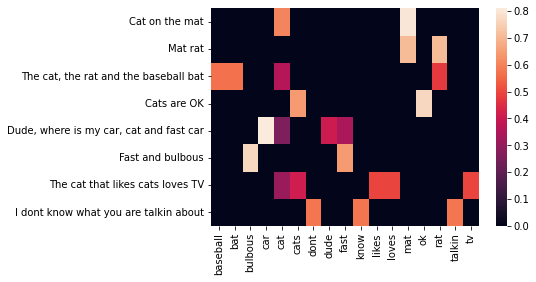

In [52]:
_=sns.heatmap(tfidf_df)

Straight away we can see that TF-IDF is different from bag of words in that occurrences of words in the texts are weighted differently. Bag-of-words feature extraction, values in the results matrix was a whole number, being the count of the word in each text.

TF-IDF has different values for each word/instance combination. Notice that:
- The double "car" has a high feature value similar to bag-of-words result before,
- "Bulbous" and "OK" are identified as unusual words in the text corpus, and so have larger feature values.
- "Cat" is pretty frequent across all texts, and so when it does occur it has a relatively small feature value.
- When a word is part of a smaller-length sentence it assumes more importance (the "cat" in "cat on the mat" is more important than the "cat" in "The cat, the rat and the baseball bat").
- Within a text, less frequent words are more important than more frequent words ("cat" is less important than "TV" in "The cat that likes cats loves TV").

N-grams (two or more words) can also be considered, which identifies unusual combinations of words in a corpus.

## 6.2 Letter-level TF-IDF

If I know anything about HPL, it is that he was prone to making up ridiculous sounding names and utterances using uncommon combinations of letters, e.g.:


In [53]:
print(data.loc[data['id']=="id26901",'text'].iloc[0])

Hieroglyphics had covered the walls and pillars, and from some undetermined point below had come a voice that was not a voice; a chaotic sensation which only fancy could transmute into sound, but which he attempted to render by the almost unpronounceable jumble of letters, "Cthulhu fhtagn".


One way to extract this kind of information is using letter-level TF-IDF. Basically, treat individual charaters as words, and increase the value of `ngram_range`, which considers multiple letters

In [54]:
tfidf2_vec = TfidfVectorizer(max_features=None, 
                strip_accents='unicode', analyzer='char_wb',
                ngram_range=(3, 3), 
                stop_words = 'english')

tfidf2 = tfidf2_vec.fit_transform(silly_examples)
tfidf2_df = pd.DataFrame(data=tfidf2.todense(),index=silly_examples,columns = tfidf2_vec.get_feature_names_out())

tfidf2_df

,ab,an,ar,ba,bu,ca,do,du,fa,i,...,ts,tv,ude,ulb,us,ut,ves,wha,whe,you
Cat on the mat,0.000000,0.000000,0.000000,0.000000,0.000000,0.218430,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mat rat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"The cat, the rat and the baseball bat",0.000000,0.126422,0.000000,0.349621,0.000000,0.098116,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cats are OK,0.000000,0.000000,0.343217,0.000000,0.000000,0.229856,0.000000,0.000000,0.000000,0.000000,...,0.343217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Dude, where is my car, cat and fast car",0.000000,0.136661,0.000000,0.000000,0.000000,0.318189,0.000000,0.188969,0.158371,0.000000,...,0.000000,0.000000,0.188969,0.000000,0.000000,0.000000,0.000000,0.000000,0.188969,0.000000
Fast and bulbous,0.000000,0.217253,0.000000,0.000000,0.300409,0.000000,0.000000,0.000000,0.251766,0.000000,...,0.000000,0.000000,0.000000,0.300409,0.300409,0.000000,0.000000,0.000000,0.000000,0.000000
The cat that likes cats loves TV,0.000000,0.000000,0.000000,0.000000,0.000000,0.230272,0.000000,0.000000,0.000000,0.000000,...,0.171919,0.205134,0.000000,0.000000,0.000000,0.000000,0.205134,0.000000,0.000000,0.000000
I dont know what you are talkin about,0.191444,0.000000,0.160445,0.000000,0.000000,0.000000,0.191444,0.000000,0.000000,0.191444,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.191444,0.000000,0.191444,0.000000,0.191444


# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">7. Combining style, words, and character features</p>

Next, we put this all together into a pipeline. 

I ran into some problems when `analyzer` is equal to 'char_wb' in the call to scikit-learn's `TfidfVectorizer` (i.e. for letter-level TF-IDF). Basically, [TfidfVectorizer calculates ngrams across words](https://stackoverflow.com/questions/74257904/eliminate-unigrams-in-char-level-tf-idf) (i.e. including spaces). I'd rather get ngrams within words, so [I put together a custom analyzer](https://stackoverflow.com/a/74258388/14278409) callable based on the source code of `TfidfVectorizer`, which is `char_wb_ngrams()` below. The specification of `ngram_range` gets a bit fiddly, so I created a transformer class for this directly, which is `NgramVectorizer`. That way, `ngram_range` can be specified directly in, for example, `GridSearchCV`, which we do later. 

There is also an option to preprocess text by stripping out punctuation. Once again, we'll consider the effect of this when tuning hyperparameters below. 

In [55]:
from functools import partial

def strip_punctuation(astr):
    stripped = astr
    for p in punct:
        stripped = stripped.replace(p,'')
    return stripped
def char_wb_ngrams(text_document, ngram_range):
    """Callable for TfidfVectorizer analyzer, based on _char_wb_ngrams from TfidfVectorizer source code at
    https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b6/sklearn/feature_extraction/text.py"""

    # See https://stackoverflow.com/questions/74257904/eliminate-unigrams-in-char-level-tf-idf
    
    ngrams = []
    min_n, max_n = ngram_range

    for w in text_document.lower().split():
        # This line in _char_wb_ngrams pads words with spaces and needs to be removed:
        #w = " " + w + " "
        w_len = len(w)
        for n in range(min_n, max_n + 1):
            offset = 0
            ngrams.append(w[offset : offset + n])
            while offset + n < w_len:
                offset += 1
                ngrams.append(w[offset : offset + n])
            if offset == 0:  # count a short word (w_len < n) only once
                break
    return ngrams
def char_wb_ngrams_stripped(text_document, ngram_range):
    return char_wb_ngrams(strip_punctuation(text_document), ngram_range)
class NgramVectorizer(FeatureExtractionClass):
    def __init__(self, ngram_range, strip_punctuation = True):
        self.ngram_range = ngram_range
        self.strip_punctuation = strip_punctuation
    def get_feature_names_out(self, input_features=None):
        return self.vectorizer.get_feature_names_out(input_features)
    def fit(self, X, y=None):
        if self.strip_punctuation:
            self.vectorizer = TfidfVectorizer(max_features=None, 
                                              strip_accents='unicode', 
                                              analyzer=partial(char_wb_ngrams_stripped, 
                                                               ngram_range=self.ngram_range))
        else:
            self.vectorizer = TfidfVectorizer(max_features=None, 
                                              strip_accents='unicode', 
                                              analyzer=partial(char_wb_ngrams, 
                                                               ngram_range=self.ngram_range))
                
        self.vectorizer.fit(X, y)
        return self
    def transform(self, X, y=None):
        return self.vectorizer.transform(X)


## 7.1 XGBoost pipeline

And now, assemble the pipeline with an XGBoost model as the final estimator in the pipeline.

In [56]:
from sklearn.compose import ColumnTransformer

xgb_pipe_with_tfidf = Pipeline([('feature_extraction', 
                                 FeatureUnion([('style_features', StyleExtractor),
                                               ('tf_idf', ColumnTransformer(transformers=[('just_on_text_column',
                                                                                           FeatureUnion([('word_tf_idf', TfidfVectorizer(max_features=None, 
                                                                                                                                         strip_accents='unicode', 
                                                                                                                                         analyzer='word', 
                                                                                                                                         token_pattern=r'\w{1,}',
                                                                                                                                         ngram_range=(1, 1), 
                                                                                                                                         stop_words = 'english')),
                                                                                                         ('letter_tf_idf', NgramVectorizer(ngram_range = (2,3)))]),
                                                                                                                           
                                                                                           'text'),], # To apply just to the text column
                                                                            remainder='drop'))])),
                                ('xgb_classifier', XGBClassifier(n_estimators=25 if QUICKRUN else 100, 
                                                                 tree_method = xgboost_tree_method))])


A few words on the pipeline. The style features extraction is applied using a `FeatureUnion`, as before. Since we use the 'text_length' and 'nwords' columns for this, we pass the whole dataset into the `FeatureUnion`. The TF-IDF vectorizers work only on the 'text' column, so this needs to be passed into a `ColumnTransformer` that works just on the one column. Within the `ColumnTransformer`, the two TF-IDF vectorizers are also placed within a `FeatureUnion`. After these transformations, we apply the model to the output.

In [57]:
xgb_pipe_with_tfidf

Pipeline(steps=[('feature_extraction',
                 FeatureUnion(transformer_list=[('style_features',
                                                 FeatureUnion(transformer_list=[('text_length',
                                                                                 TextLength()),
                                                                                ('punctuation_proportion',
                                                                                 CountPunctuationProp()),
                                                                                ('semicolon_count',
                                                                                 CountSemicolons()),
                                                                                ('std_word_length',
                                                                                 StdWordLength()),
                                                                                ('stopwords_proportion',
                                                                                 CountStopsProp(stopwords={'a',
                                                                                                           'about',
                                                                                                           'above',
                                                                                                           'after',
                                                                                                           '...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

In [58]:
%%time 
_=xgb_pipe_with_tfidf.fit(data, author_codes)


CPU times: user 11min, sys: 855 ms, total: 11min 1s
Wall time: 2min 55s


In [59]:
%%time
xgb2_author_probs = xgb_pipe_with_tfidf.predict_proba(data)



CPU times: user 6.23 s, sys: 81.9 ms, total: 6.31 s
Wall time: 5.81 s


In [60]:
print(f'Calibration log-loss score (XGB model): {log_loss(author_codes, xgb2_author_probs):.3f}')

Calibration log-loss score (XGB model): 0.339


In [61]:
%%time

XGBcvscore = cross_validate(estimator = xgb_pipe_with_tfidf, 
                            cv = sfold5, 
                            scoring = 'neg_log_loss',
                            return_estimator = True,
                            X = data, y=author_codes)
              
print(f'Average validation log-loss score (XGB model): {-np.mean(XGBcvscore["test_score"]):.3f}')

Average validation log-loss score (XGB model): 0.618
CPU times: user 43min 28s, sys: 2.95 s, total: 43min 31s
Wall time: 11min 36s


Cross-validated confusion matrix: XGB model
Fold 1: cv log loss: 0.623
Fold 2: cv log loss: 0.616
Fold 3: cv log loss: 0.623
Fold 4: cv log loss: 0.615
Fold 5: cv log loss: 0.613
[[6469  683  748]
 [1238 3984  413]
 [1402  527 4115]]


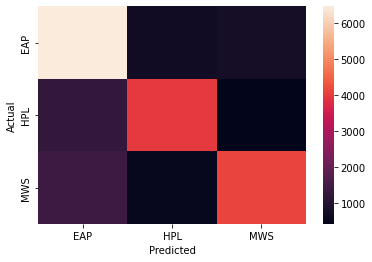

In [62]:
print('Cross-validated confusion matrix: XGB model')
plot_cv_confusion_matrix(XGBcvscore, sfold5)

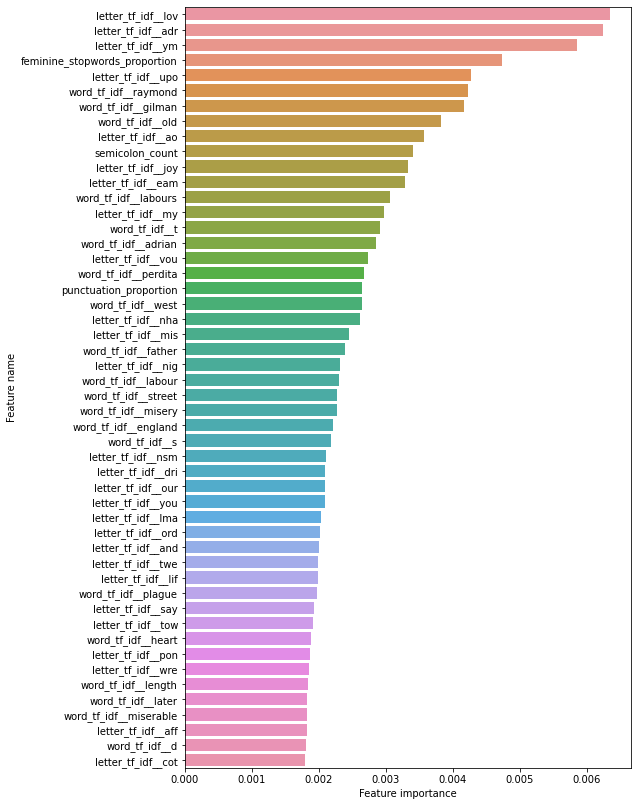

In [63]:
feature_names = [x[0] for x in StyleExtractor.transformer_list] + \
                [x.replace('just_on_text_column__','') for x in xgb_pipe_with_tfidf.steps[0][1].transformer_list[1][1].get_feature_names_out()]

plt.figure(figsize=(8,14))
feature_importance = xgb_pipe_with_tfidf.steps[-1][1].feature_importances_
important_feature_names = [feature_names[x] for x in np.argsort(feature_importance)[::-1][:50]]
plotdata=pd.DataFrame({'Feature name':important_feature_names,
                      'Feature importance':[feature_importance[x] for x in np.argsort(feature_importance)[::-1][:50]]})
_=sns.barplot(data=plotdata, x = 'Feature importance', y= 'Feature name')

The important features here tend to be a mix of the style-based features (feminine stop words and punctuation especially), word-based TF-IDF features (particularly proper nouns such as "Raymond" and "Perdita") and the character-based TF-IDF features, which tend to be closely associated with particular words ("lov" is clearly "love"/"loved"/"loving", etc.), rather than the uncommon ngrams like "fht" that I assumed would be associated with HPL.

## 7.2 Multinomial Naive Bayes pipeline

Let's see how the MNB model performs with all the engineered features in the pipeline.

In [64]:
MNB_pipe_with_tfidf = Pipeline([xgb_pipe_with_tfidf.steps[0],
                               ('MNB', MultinomialNB())])
MNB_pipe_with_tfidf

Pipeline(steps=[('feature_extraction',
                 FeatureUnion(transformer_list=[('style_features',
                                                 FeatureUnion(transformer_list=[('text_length',
                                                                                 TextLength()),
                                                                                ('punctuation_proportion',
                                                                                 CountPunctuationProp()),
                                                                                ('semicolon_count',
                                                                                 CountSemicolons()),
                                                                                ('std_word_length',
                                                                                 StdWordLength()),
                                                                                ('stopwords_proportion',
                                                                                 CountStopsProp(stopwords={'a',
                                                                                                           'about',
                                                                                                           'above',
                                                                                                           'after',
                                                                                                           '...
                                                                                                           'herself',
                                                                                                           'she',
                                                                                                           "she's"])),
                                                                                ('allcaps_count',
                                                                                 CountAllcaps())])),
                                                ('tf_idf',
                                                 ColumnTransformer(transformers=[('just_on_text_column',
                                                                                  FeatureUnion(transformer_list=[('word_tf_idf',
                                                                                                                  TfidfVectorizer(stop_words='english',
                                                                                                                                  strip_accents='unicode',
                                                                                                                                  token_pattern='\\w{1,}')),
                                                                                                                 ('letter_tf_idf',
                                                                                                                  NgramVectorizer(ngram_range=(2,
                                                                                                                                               3)))]),
                                                                                  'text')]))])),
                ('MNB', MultinomialNB())])

In [65]:
%%time
MNB_pipe_with_tfidf.fit(data, author_codes)
print(f'Calibration log-loss score (MNB model): {log_loss(author_codes, MNB_pipe_with_tfidf.predict_proba(data)):.3f}')

Calibration log-loss score (MNB model): 0.395
CPU times: user 14.2 s, sys: 198 ms, total: 14.4 s
Wall time: 14.4 s


In [66]:
MNBcvscore = cross_validate(estimator = MNB_pipe_with_tfidf, 
                            cv = sfold5, 
                            scoring = 'neg_log_loss', 
                            return_estimator = True,              
                            X = data, y=author_codes)

print(f'Average validation log-loss score (MNB model): {-np.mean(MNBcvscore["test_score"]):.3f}')

Average validation log-loss score (MNB model): 0.553


Whereas the XGBoost model including TF-IDF features does better in training-set log loss compared to cross-validated log loss, the MNB model including TF-IDF does better in the average cross-validated log loss. This suggests that the XGB pipe as implemented above is overfitting the training data. The confusion matrix from the MNB model looks pretty good, although the main problem seems to be HPL texts miscategorised as EAP:

Cross-validated confusion matrix: MNB model
Fold 1: cv log loss: 0.571
Fold 2: cv log loss: 0.547
Fold 3: cv log loss: 0.550
Fold 4: cv log loss: 0.551
Fold 5: cv log loss: 0.544
[[7170  216  514]
 [1873 3370  392]
 [1337  125 4582]]


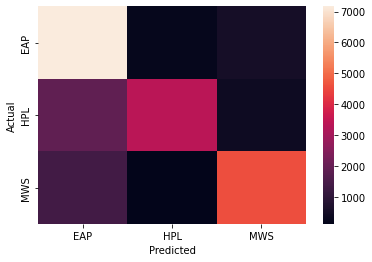

In [67]:
print('Cross-validated confusion matrix: MNB model')
plot_cv_confusion_matrix(MNBcvscore, sfold5)

## 7.3 Latent Semantic Analysis

I also considered a [TruncatedSVD](https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author) aggregation of the TF-IDF features (also known as [Latent Semantic Analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis), but this didn't seem to improve predictions. Something to look into further!

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">8. Parameter tuning</p>

It wouldn't be a kaggle notebook without a little hyperparameter tuning 😂. Luckily `MultinomialNB` has a smoothing parameter $\alpha$ that we can tune. Also, I try out a few different options for the word- and character-level TF-IDF ngram range, and whether or not we strip punctuation from text before the character-level TF-IDF processing.

In [68]:
%%time
param_grid = {'MNB__alpha':[0.05,0.1],
              'feature_extraction__tf_idf__just_on_text_column__word_tf_idf__ngram_range':[(1,1)],
              'feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__ngram_range':[(2,3)],
              'feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__strip_punctuation': [True, False]} if QUICKRUN else \
             {'MNB__alpha':[0.01,0.04,0.05,0.065,0.1],
              'feature_extraction__tf_idf__just_on_text_column__word_tf_idf__ngram_range':[(1,1), (1,2)],
              'feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__ngram_range':[(2,3), (3,4), (2, 4)],
              'feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__strip_punctuation': [True, False]}
from sklearn.model_selection import GridSearchCV
gscv = GridSearchCV(estimator = MNB_pipe_with_tfidf,
                    cv = sfold5,
                    scoring = 'neg_log_loss',
                    param_grid = param_grid)


_=gscv.fit(data, author_codes)

print(f'Best alpha parameter: {gscv.best_params_["MNB__alpha"]}')

Best alpha parameter: 0.04
CPU times: user 45min 9s, sys: 28.5 s, total: 45min 38s
Wall time: 45min 43s


Best results are obtained for the smoothing parameter $\alpha$ around 0.05 rather than the default provided by scikit-learn of 1.

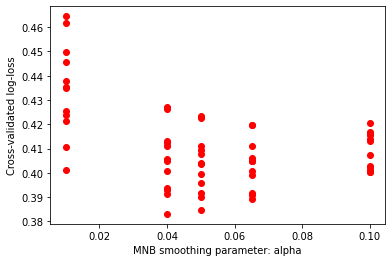

In [69]:
plt.plot(gscv.cv_results_['param_MNB__alpha'].data, -gscv.cv_results_['mean_test_score'],'ro')
_=plt.gca().set_ylabel('Cross-validated log-loss')
_=plt.gca().set_xlabel('MNB smoothing parameter: alpha')

Let's see the minimum value for each non-$\alpha$ parameter combination.

In [70]:
cvres_df = pd.DataFrame({'alpha': gscv.cv_results_['param_MNB__alpha'].data,
                         'strip_punctuation': gscv.cv_results_['param_feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__strip_punctuation'].data,
                         'word_ngram_range': gscv.cv_results_['param_feature_extraction__tf_idf__just_on_text_column__word_tf_idf__ngram_range'].data,
                         'letter_ngram_range': gscv.cv_results_['param_feature_extraction__tf_idf__just_on_text_column__letter_tf_idf__ngram_range'].data,
                         'score': -gscv.cv_results_['mean_test_score']
                         })
pd.DataFrame(cvres_df.groupby(['word_ngram_range','letter_ngram_range','strip_punctuation',])['score'].min())

score
word_ngram_range letter_ngram_range strip_punctuation          
(1, 1)           (2, 3)             False              0.399240
                                    True               0.410864
                 (2, 4)             False              0.402342
                                    True               0.416868
                 (3, 4)             False              0.402949
                                    True               0.416163
(1, 2)           (2, 3)             False              0.383068
                                    True               0.393639
                 (2, 4)             False              0.389983
                                    True               0.403807
                 (3, 4)             False              0.391482
                                    True               0.404161

In [71]:
%%time
prediction_probabilities = gscv.best_estimator_.predict_proba(test)
gscv.best_estimator_

CPU times: user 2.64 s, sys: 1.02 ms, total: 2.64 s
Wall time: 2.66 s


Pipeline(steps=[('feature_extraction',
                 FeatureUnion(transformer_list=[('style_features',
                                                 FeatureUnion(transformer_list=[('text_length',
                                                                                 TextLength()),
                                                                                ('punctuation_proportion',
                                                                                 CountPunctuationProp()),
                                                                                ('semicolon_count',
                                                                                 CountSemicolons()),
                                                                                ('std_word_length',
                                                                                 StdWordLength()),
                                                                                ('stopwords_proportion',
                                                                                 CountStopsProp(stopwords={'a',
                                                                                                           'about',
                                                                                                           'above',
                                                                                                           'after',
                                                                                                           '...
                                                                                 CountAllcaps())])),
                                                ('tf_idf',
                                                 ColumnTransformer(transformers=[('just_on_text_column',
                                                                                  FeatureUnion(transformer_list=[('word_tf_idf',
                                                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                                                               2),
                                                                                                                                  stop_words='english',
                                                                                                                                  strip_accents='unicode',
                                                                                                                                  token_pattern='\\w{1,}')),
                                                                                                                 ('letter_tf_idf',
                                                                                                                  NgramVectorizer(ngram_range=(2,
                                                                                                                                               3),
                                                                                                                                  strip_punctuation=False))]),
                                                                                  'text')]))])),
                ('MNB', MultinomialNB(alpha=0.04))])

The minimum value occurs when we extract both 1- and 2-gram words, and 2- and 3-gram letters. More complicated letter combinations overfit the data. Interestingly enough, not stripping the punctuation before extracting the character-level TF-IDF provides a slightly better cross-validated fit. 

In [72]:
%%time
# Refit over the cv folds to get validation confusion matrix
finalcvscore = cross_validate(estimator = gscv.best_estimator_, 
                              cv = sfold5, 
                              scoring = 'neg_log_loss', 
                              return_estimator = True,              
                              X = data, y=author_codes)

print(f'Average validation log-loss score (final model): {-np.mean(finalcvscore["test_score"]):.3f}')


Average validation log-loss score (final model): 0.383
CPU times: user 46 s, sys: 524 ms, total: 46.6 s
Wall time: 46.9 s


Cross-validated confusion matrix
Fold 1: cv log loss: 0.383
Fold 2: cv log loss: 0.373
Fold 3: cv log loss: 0.395
Fold 4: cv log loss: 0.397
Fold 5: cv log loss: 0.367
[[6831  381  688]
 [ 712 4610  313]
 [ 696  214 5134]]


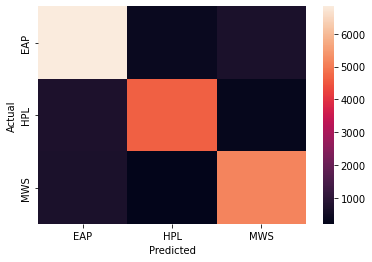

In [73]:
finalcv_probs = np.zeros((data.shape[0],3))
for i,xy in enumerate(sfold5.split(data, author_codes)):
    fold_ix=xy[1]
    finalcv_probs[fold_ix,:] = finalcvscore['estimator'][i].predict_proba(data.iloc[fold_ix,:])
    #print(log_loss(data.iloc[fold_ix,:]['author'],
    #               XGBcvscore['estimator'][i].predict_proba(data.iloc[fold_ix,:])))
print('Cross-validated confusion matrix')
plot_cv_confusion_matrix(finalcvscore, sfold5)

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">9. Submit predictions</p>

The submission format is three columns of probabilities for each row, and we can get this using the `predict_proba` method from the pipeline.

In [74]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [75]:

submission = sample.copy()
submission.iloc[:,1:] = prediction_probabilities
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.045078,0.001938,0.952984
1,id24541,0.966319,0.010504,0.023177
2,id00134,0.177615,0.821224,0.001161
3,id27757,0.766775,0.232628,0.000596
4,id04081,0.924416,0.049970,0.025614


In [76]:
submission.to_csv('submit.csv', index=False)

# <p style="background-color:darkred;color:white;font-family:verdana;font-size:120%;text-align:center;border-radius: 15px 50px;">10. References</p>

## Useful notebooks that I used:

- [Maheshdadhich (BuryBuryZamon) - Creative Feature Engineering](https://www.kaggle.com/code/maheshdadhich/creative-feature-engineering-lb-0-35)

- [sudalairajkumar (SRK) Simple Feature Engg Notebook](https://www.kaggle.com/code/sudalairajkumar/simple-feature-engg-notebook-spooky-author)

- [Fares Sayah (faressayah) Natural Language Processing (NLP) for beginners](https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners)

- [Shubham Singh (shubhamksingh) Create Beautiful Notebooks Formatting Tutorial](https://www.kaggle.com/code//create-beautiful-notebooks-formatting-tutorial](https://www.kaggle.com/code/shubhamksingh/create-beautiful-notebooks-formatting-tutorial)

- [Melike Dilekci (melikedilekci) For a More Beautiful Notebook 1](https://www.kaggle.com/code/melikedilekci/for-a-more-beautiful-notebook-1)

## Image credits
- EAP image: Unknown author; Restored by Yann Forget and Adam Cuerden, Public domain, via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Edgar_Allan_Poe,_circa_1849,_restored,_squared_off.jpg)
- HPL image: Lucius B. Truesdell, Public domain, via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:H._P._Lovecraft,_June_1934.jpg)
- MWS image: Richard Rothwell, Public domain, via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:MaryShelley.jpg)
    